<a href="https://colab.research.google.com/github/ajankowi/Praca_inz/blob/master/Siec/Zlaczone_siec_4_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.version)

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


print("TensorFlow version:", tf.__version__)
tf.keras.backend.set_floatx('float64')

TensorFlow version: 2.9.2


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import csv
import random

import cv2
import imutils
import glob
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
#Określenie ścieżek do plików
folder = '/content/drive/MyDrive/test/Baza_zdjec_zlaczone_2/'
nazwa_CSV = 'nowe.csv'
#folder_aktorzy = '../../Dane/Baza_aktorzy_zlaczone/'
#nazwa_aktorzy_CSV = 'nowe.csv'
slesh = '/'
png = '.png'

In [6]:
def release_list(a):
    
    del a[:]
    del a

In [7]:
#Wczytanie pliku CSV do tablicy images

with open(folder+nazwa_CSV,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value = []
for i in new[0]:
    value.append(int(i))    
    
print(len(value))

25200


In [8]:
#Wczytanie zdjęć do tablicy images
images = []
size = len(value)

for i in range(size):
    im = Image.open('/content/drive/MyDrive/test/Baza_zdjec_zlaczone_2/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images.append(arr_im) 
print(len(images))

25200


In [9]:
#Inicjalizacja tablic
rand_list = []
rand_list = np.zeros((len(images)), dtype=np.uint8)

x_test = []
y_test = []

x_train = []
y_train = []


#Okreslanie wielkosci zbiorów
eighty = int(len(images)*80/100)
twenty = len(images) - eighty

#Losowanie zbioru testowego
for i in range(eighty):
    
    #Pierwsze losowanie wartości
    rand = random.randint(0,len(images)-1)
    
    #Sprawdzenie czy wylosowana wartość się powtarza
    while (rand_list[rand] == 1) :
        #Jeżeli tak to ponownie losuje
        rand = random.randint(0,len(images)-1)
    
    #Zapisanie zdjecia i wartości do nowej tablicy
    x_train.append(images[rand])
    y_train.append(value[rand])
    rand_list[rand] = 1

#Losowanie zbioru uczącego
for j in range(twenty):
    
    #Pierwsze losowanie wartości
    rand = random.randint(0,len(images)-1)
    
    #Sprawdzenie czy wylosowana wartość się powtarza
    while (rand_list[rand] == 1) :
        #Jeżeli tak to ponownie losuje
        rand = random.randint(0,len(images)-1)
        
    #Zapisanie zdjecia i wartości do nowej tablicy
    x_test.append(images[rand])
    y_test.append(value[rand])
    rand_list[rand] = 1
    
    
release_list(images)
release_list(value)

In [10]:
#Sprawdzenie poprawności losowania
val_1 = 100 * sum(y_test) / (size / 2)
print("%.2f" % val_1 + '%') 


val_2 = 100 * sum(y_train) / (size / 2)
print("%.2f" % val_2 + '%') 




20.09%
79.91%


In [11]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

[[0.    0.    0.    ... 0.325 0.294 0.   ]
 [0.227 0.149 0.137 ... 0.325 0.314 0.   ]
 [0.196 0.133 0.125 ... 0.325 0.325 0.   ]
 ...
 [0.    0.247 0.247 ... 0.188 0.192 0.2  ]
 [0.    0.243 0.247 ... 0.188 0.188 0.184]
 [0.    0.239 0.259 ... 0.    0.    0.   ]]


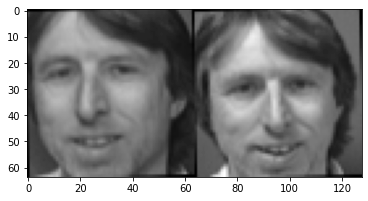

In [12]:
plt.imshow(x_train[0],cmap = 'gray')
print(x_train[0])

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 126, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 28, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 21504)             0

In [16]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy','mse'])

#Funcka umożliwia zatrzymanie się uczenia 
#gdy wartość strat przstanie maleć
EarlyStop = EarlyStopping(monitor='val_loss',  
                          verbose=1, 
                          patience=5)


#ModelCheck = ModelCheckpoint(filepath='Zlaczone.h5',
#                             monitor='var_loss',
#                             save_best_only=True)


history = model.fit(x=x_train, 
                    y=y_train, 
                    epochs=40,
                    batch_size=512,
                    validation_split=0.1,
                    callbacks = [EarlyStop]
                   )

Epoch 1/40
36/36 [==============================] - 29s 800ms/step - loss: 0.3239 - accuracy: 0.4796 - mse: 0.3239 - val_loss: 0.2604 - val_accuracy: 0.4350 - val_mse: 0.2604
Epoch 2/40
36/36 [==============================] - 29s 795ms/step - loss: 0.2388 - accuracy: 0.5719 - mse: 0.2388 - val_loss: 0.1945 - val_accuracy: 0.7173 - val_mse: 0.1945
Epoch 3/40
36/36 [==============================] - 28s 792ms/step - loss: 0.1917 - accuracy: 0.6887 - mse: 0.1917 - val_loss: 0.1659 - val_accuracy: 0.7599 - val_mse: 0.1659
Epoch 4/40
36/36 [==============================] - 29s 795ms/step - loss: 0.1580 - accuracy: 0.7825 - mse: 0.1580 - val_loss: 0.1438 - val_accuracy: 0.8061 - val_mse: 0.1438
Epoch 5/40
36/36 [==============================] - 29s 794ms/step - loss: 0.1401 - accuracy: 0.8176 - mse: 0.1401 - val_loss: 0.1297 - val_accuracy: 0.8313 - val_mse: 0.1297
Epoch 6/40
36/36 [==============================] - 29s 794ms/step - loss: 0.1165 - accuracy: 0.8564 - mse: 0.1165 - val_loss

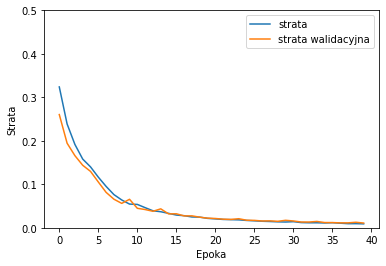

In [17]:
plt.plot(history.history['loss'], label='strata')
plt.plot(history.history['val_loss'], label = 'strata walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.ylim([0.0, 0.5])
plt.legend(loc='upper right')

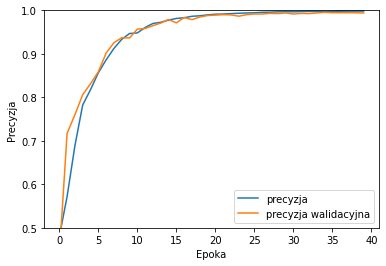

In [18]:
plt.plot(history.history['accuracy'], label='precyzja')
plt.plot(history.history['val_accuracy'], label = 'precyzja walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Precyzja')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [19]:
model.evaluate(x_test,  y_test, verbose=2)

158/158 - 3s - loss: 0.0110 - accuracy: 0.9978 - mse: 0.0110 - 3s/epoch - 20ms/step


[0.011036468315169138, 0.9978174603174603, 0.011036468315169138]

In [21]:
predict_x = model.predict(x_test) 

predictions = (predict_x > 0.5).astype("int32")

158/158 [==============================] - 3s 19ms/step


In [22]:
names = [['Tn','Nn'],['Np', 'Tp']]
names = np.reshape(names,(2,2))
print(names)

tf.math.confusion_matrix(y_test,predictions)

[['Tn' 'Nn']
 ['Np' 'Tp']]


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[2499,   10],
       [   1, 2530]], dtype=int32)>

In [ ]:
#Wczytanie zdjęć aktorów

In [ ]:
with open(folder_aktorzy+nazwa_aktorzy_CSV,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()


tmp = []
act_label = []

for i in lines:
    tmp.append(i.split(" "))

    
act_label = []
for i in tmp[0]:
    act_label.append(int(i))    
    
print(len(act_label))

2837


In [ ]:
#Wczytanie zdjęć aktorów do tablicy

act = []
size = len(act_label)

for i in range(size):
    im = Image.open(folder_aktorzy+str(i)+png)
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    act.append(arr_im) 
print(len(act))

2837


[[0.984 0.984 0.984 ... 0.192 0.196 0.196]
 [0.984 0.984 0.98  ... 0.2   0.192 0.192]
 [0.984 0.98  0.976 ... 0.204 0.196 0.192]
 ...
 [0.98  0.98  0.98  ... 0.298 0.294 0.29 ]
 [0.98  0.98  0.98  ... 0.294 0.298 0.302]
 [0.98  0.98  0.98  ... 0.298 0.31  0.302]]


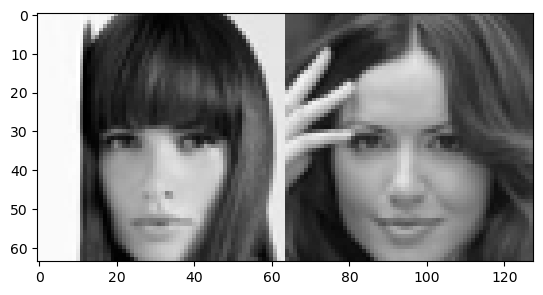

In [ ]:
plt.imshow(act[0],cmap = 'gray')
print(act[0])

In [ ]:
act= np.array(act)

In [ ]:
#Testowanie sieci z wykorzystaniem zdjęć aktorów 
act_prob = probability_model(act)

2022-12-01 19:20:18.082980: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (mklcpu) ran out of memory trying to allocate 5.28GiB (rounded to 5673636864)requested by op Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-12-01 19:20:18.083059: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for mklcpu
2022-12-01 19:20:18.083070: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-12-01 19:20:18.083075: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-12-01 19:20:18.083079: I tensorflow/core/common_runtime/bfc_alloc

ResourceExhaustedError: Exception encountered when calling layer "conv2d" (type Conv2D).

OOM when allocating tensor with shape[2837,62,126,32] and type double on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:Conv2D]

Call arguments received:
  • inputs=tf.Tensor(shape=(2837, 64, 128, 1), dtype=float64)

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))